## imports

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, Conv3DTranspose, Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam, Adamax
import matplotlib.pyplot as plt

import numpy as np

import glob

import nibabel as nib
from nibabel.testing import data_path

## Diagram for reference

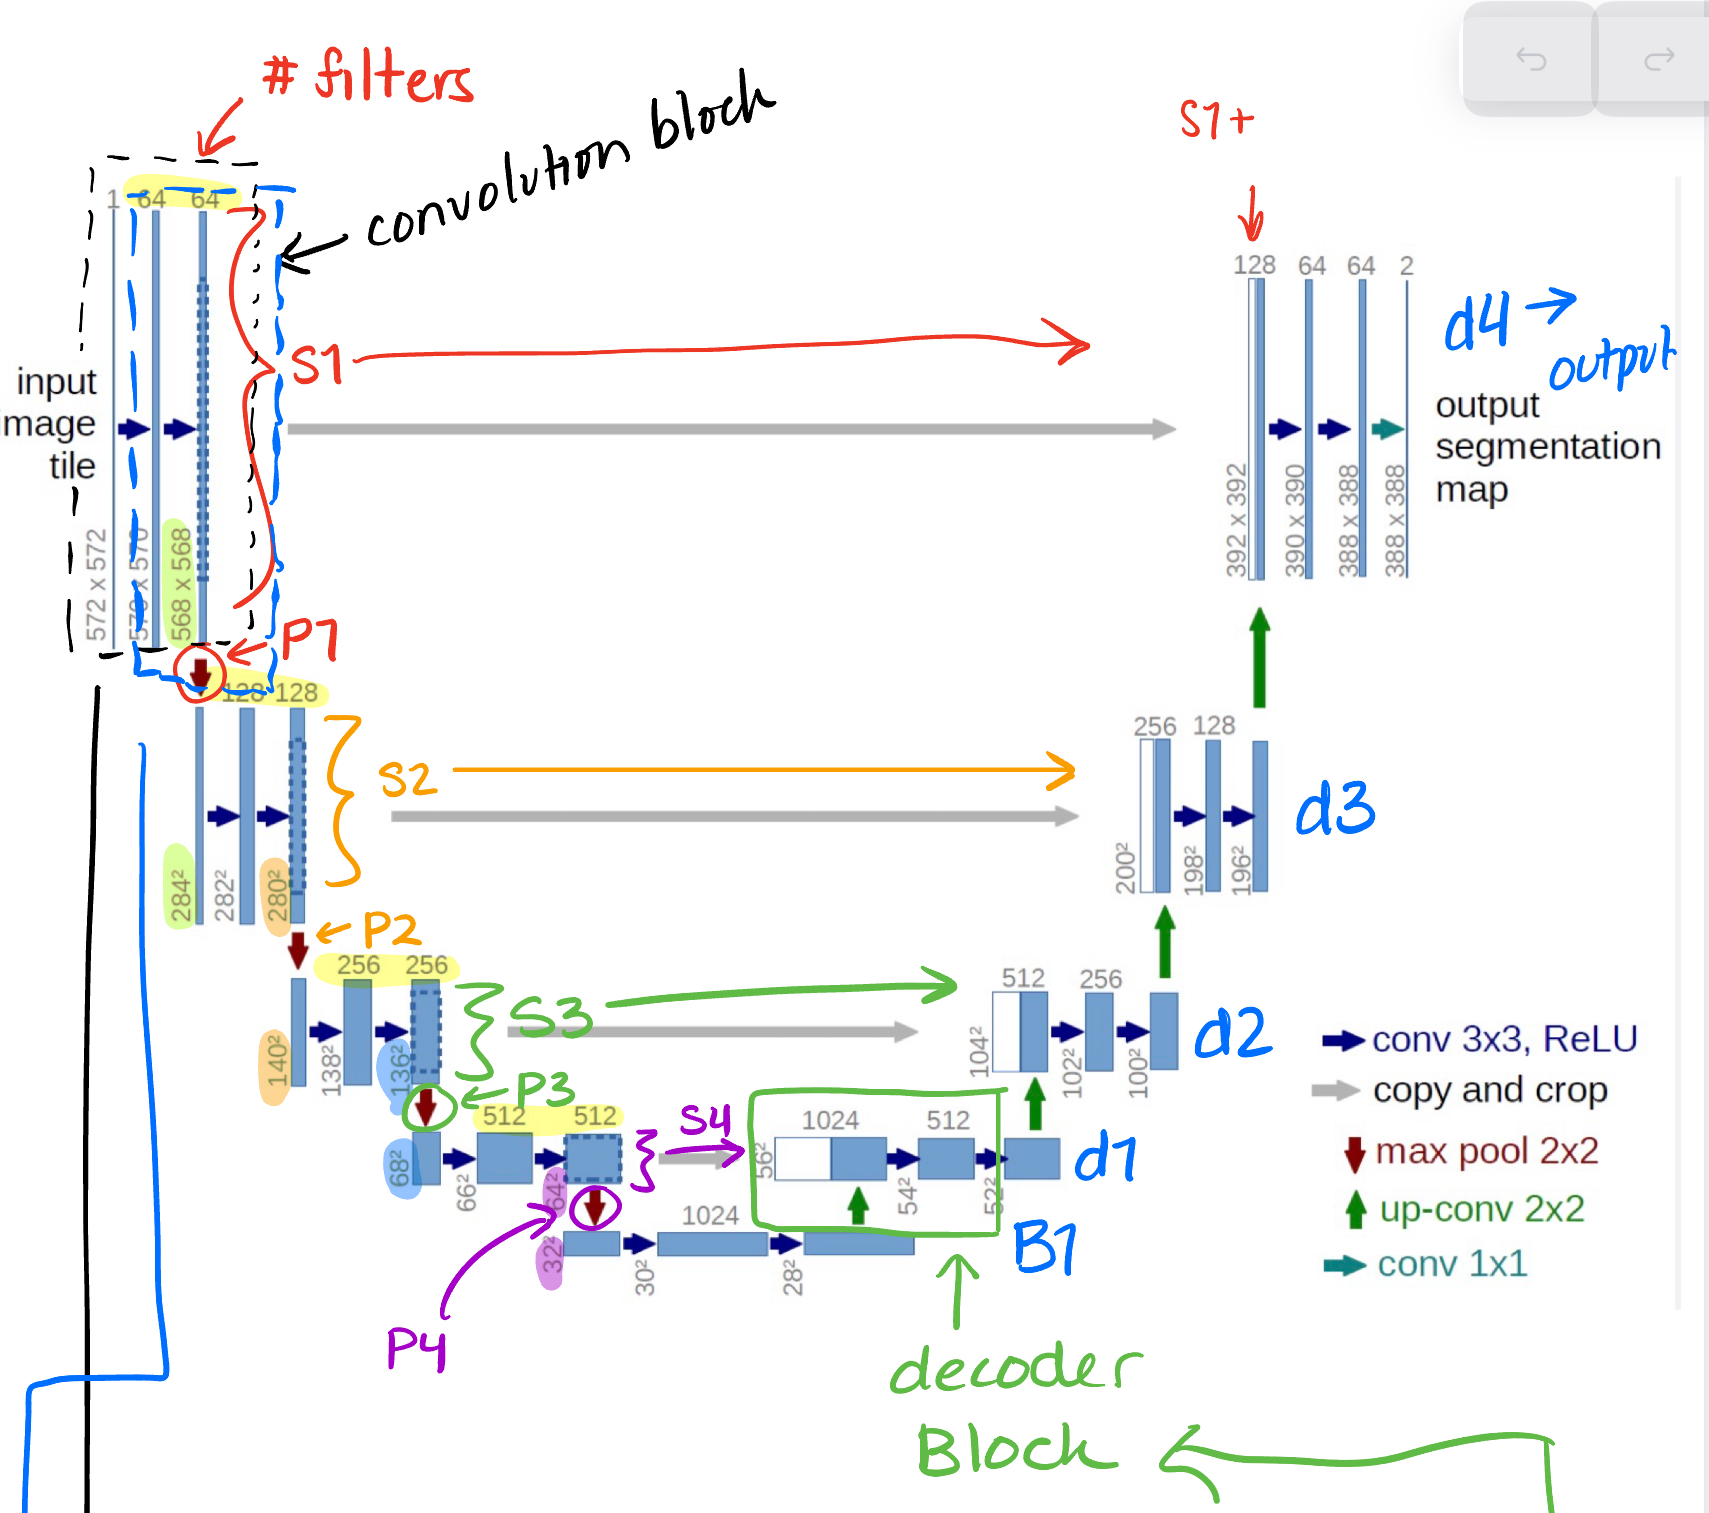

In [10]:
from IPython.display import Image, display
display(Image(filename='2d_unet_ex.jpg'))

## Loading data


In [6]:
def load_data(path, patch_size=(64,64,64)):
    """
    patch_size = tuple containing patch size of images for training

    T1- native format 
    T1CE - contrast enhanced image of T1
    T2 - weighted
    T2 Fluid Attenuated Inversion Recovery FLAIR volumes
    """
    t1ce_all = []
    t1_all = []
    t2_all = []
    flair_all = []
    mask_all = []

    # search through MRI files and assign sample names to image files by labeling. 
    for mri_folder in os.listdir(path):
        file_path = os.path.join(path, mri_folder)

        #extracting t1ce for all 369 patients
        t1ce_files = glob.glob(os.path.join(file_path, "*_t1ce.nii")) #returns a list
        for t1ce_file in t1ce_files:
            t1ce_img = nib.load(t1ce_file)
            t1ce_img_data = t1ce_img.get_fdata()
            t1ce_all.append(t1ce_img_data)
        
        #extracting t2-weighted for all 369 patients
        t2_weighted_files = glob.glob(os.path.join(file_path, "*_t2.nii"))
        for t2_weighted_file in t2_weighted_files:
            t2_weighted_img = nib.load(t2_weighted_file)
            t2_weighted_img_data = t2_weighted_img.get_fdata()
            t2_all.append(t2_weighted_img_data)
    
        #extracting t2-flair data for all 369 patients       
        t2_flair_files = glob.glob(os.path.join(file_path, "*_flair.nii")) #returns a list
        for t2_flair_file in t2_flair_files:
            t2_flair_img = nib.load(t2_flair_file)
            t2_flair_img_data = t2_flair_img.get_fdata()
            #height, width, depth = t2_flair_img_data.shape
            #print(f'height = {height}, width = {width}, depth = {depth}')
            flair_all.append(t2_flair_img_data)
            
        #extracting t1 data for all 369 patients
        t1_files = glob.glob(os.path.join(file_path, "*_t1.nii"))
        for t1_file in t1_files:
            t1_img = nib.load(t1_file)
            t1_data = t1_img.get_fdata()
            t1_all.append(t1_data)
        
        mask_files = glob.glob(os.path.join(file_path, "*_seg.nii"))
        for mask_file in mask_files:
            mask_file_img = nib.load(mask_file)
            mask_file_img_data = mask_file_img.get_fdata()
            mask_all.append(mask_file_img_data)

    return mask_all,t1_all, t1ce_all, t2_all, flair_all

## image dimensions

t1 scan dimensions: height = 240, width = 240, depth = 155

t1ce scan dimensions: height = 240, width = 240, depth = 155

t2 scan dimensions: height = 240, width = 240, depth = 155

flair scan dimensions: 240, width = 240, depth = 155

## testing loading

In [7]:
#path specific to Julian  /Users/dolan/Dropbox/MSSE/277B_ML/277B_final/277B_final/BraTS2020_scans 

mask_data, t1_data, t1ce_data, t2_data, flair_data = load_data('/Users/dolan/Dropbox/MSSE/277B_ML/277B_final/277B_final/BraTS2020_scans')


In [ ]:
#all working
##print(t1_data[:5])
#print(t1ce_data[:5])
#print(t2_data[:5])
#print(flair_data[:5])
#print(mask_data[:5])

[memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
   

## Display image form each channel

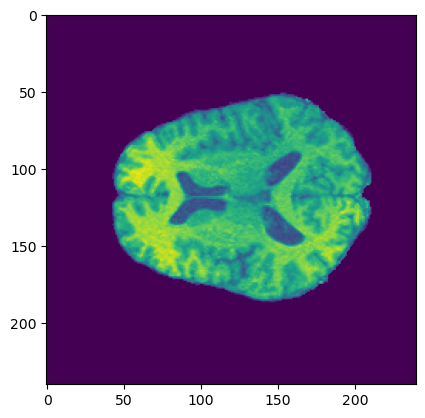

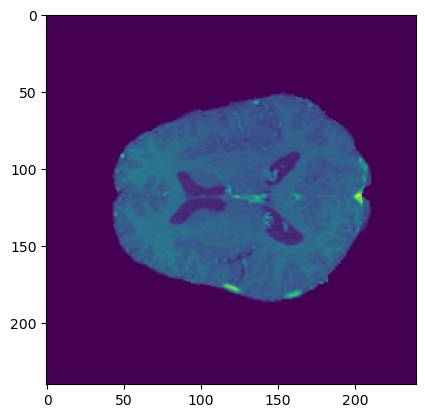

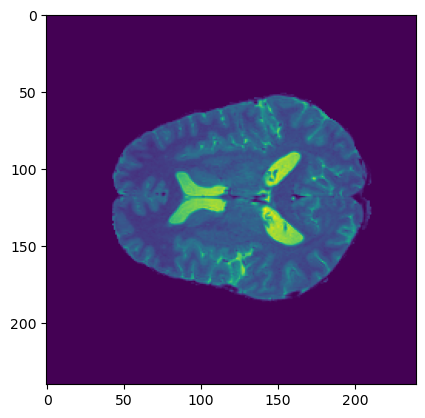

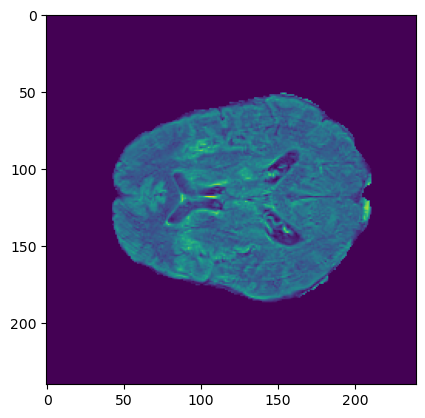

In [12]:
patient1_t1 = t1_data[0]
plt.imshow(patient1_t1[:,:,80])
plt.show()

patient1_t1ce = t1ce_data[0]
plt.imshow(patient1_t1ce[:,:,80])
plt.show()

patient1_t2 = t2_data[0]
plt.imshow(patient1_t2[:,:,80])
plt.show()

patient1_flair = flair_data[0]
plt.imshow(patient1_flair[:,:,80])
plt.show()

## EDA

missing values

outliers

display all four channels and show why we exclude t1 in data processing.

## Data Preprocessing


scale

combine all channels into one channel

crop to remove black space in scan

check if mask has labels 1,2,3 for more than 1% of the image, otherwise do not include in training 

save as numpy arr

split into training and validation

In [78]:
#Preprocessing
    

#scale image with MinMaxScaler()

def scale_data(t1ce, t2_weighted, t2_FLAIR, mask):
    scaler = MinMaxScaler()

    t1ce_scaling = scaler.fit_transform(t1ce.reshape(-1, 1)).reshape(t1ce.shape)
    t2_weighted_scaling = scaler.fit_transform(t2_weighted.reshape(-1, 1)).reshape(t2_weighted.shape)
    t2_FLAIR_scaling = scaler.fit_transform(t2_FLAIR.reshape(-1, 1)).reshape(t2_FLAIR.shape)
    mask_scaling = scaler.fit_transform(mask.reshape(-1, 1)).reshape(mask.shape) 
    
    return t1ce_scaling, t2_weighted_scaling, t2_FLAIR_scaling, mask_scaling

In [ ]:
#Preprocessing

#Combine Channels: 

def combine_channels(): 

    channel = np.concatenate(t1ce_scaling, t2_weighted_scaling, t2_FLAIR_scaling, axis=1)

    return channel


In [ ]:



def split_dataframe(t1ce_all, t2_all, flair_all, t1_all):

    X = pd.DataFrame({
        "t1ce":t1ce_all, 
        "t2": t2_all, 
        "flair":flair_all})

    y = mask_all

    # Split X and y into training (80%) and temp (20%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.8, random_state=42)

    # Split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

    # Return the split datasets
    return X_train, X_valid, X_test, y_train, y_valid, y_test

# Split the data
X_train, X_valid, X_test, y_train, y_valid, y_test = split_dataframe(df)



## Components of 3D u-net

In [5]:
def conv_block(input, n_filters):
    '''
    the input goes through two Conv3D layers, no upsampling or downsampling
    used to get output from encoder side that will be concatenated on the upsampling side of the decoder
    as well as within the downsampling and upsampling functions

    Parameters:
    ----------
    inputs: tensor 
    n_filters: int
    number of filters in convolution layer

    Returns: 
    ---------
    tensor WITHOUT any downsampling or upsampling
    '''
    #convolution layer #1
    x = Conv3D(n_filters, 3, padding = "same")(input)
    ##ADD BATCH NORMALIZATION OR DROP OUT HERE MAYBE??
    x = Activation('relu')(x)

    #convolution layer #2
    x = Conv3D(n_filters, 3, padding = "same")(x)
    ##ADD BATCH NORMALIZATION OR DROPOUT HERE??
    x = Activation('relu')(x)

    return x


def encoder_block(input, n_filters):
    '''
    Returns the resulting tensor after passing through two convolution layers and DOWNSAMPLED
    this output is necessary to descend into lower levels on the encoder side

    Parameters
    ------
    input: tensor
    n_filters: int
    the number of fiilters you want to apply

    Returns
    -------
    x: tensor after only passing through convolution layers
    p: tensor after passing through convolution layers and undergoing maxpooling
    '''
    x = conv_block(input, n_filters)
    p = MaxPool3D((2,2,2))(x)
    return x, p

def decoder_block(input, skip_features, n_filters):
    '''
    upsamples the inputs, concatenates the outputs from the encoder then pass through the convolution filters

    Parameters
    ----------
    input: tensor
    skip_features: tensor from the encoder (that has not been downsampled )
    the output from the encoder block without downsampling
    n_filters: the number of filters

    Returns
    -------
    x: tensor
    returns the tensor which results from upsampling the inputs, contatenating the input with the outputs from the encoder,
    then passing through two convolution layers

    '''
    x = Conv3DTranspose(n_filters, (2,2,2), strides = 2, padding = 'same')(input) #upsample
    x = Concatenate()([x, skip_features]) #concatenate the features from encoder and decoder
    x = conv_block(x, n_filters) #2 convolution filters
    return x

## 3d u-net

In [6]:
def build_3dunet(input_shape):

    '''
    creates a u net model which has four layers and one bridge. 
    layer filters are (16,32,64,128,256)
    activation is relu
    downsampling is 2,2,2
    upsampling is 2,2,2
    
    '''
    inputs = Input(input_shape)
    
    ### encoder side of u-net ###
    #s is will be concatenated later to the decoder side
    #p is output after maxpooling, used to descend to lower layers
    s1, p1 = encoder_block(inputs, 16) #layer 1
    s2, p2 = encoder_block(p1, 32) #layer 2
    s3, p3 = encoder_block(p2, 64) #layer 3
    s4, p4 = encoder_block(p3, 128) #layer 4

    ### bridge ###
    b1 = conv_block(p4, 256)

    ### decoder ###
    #d is the output from the decoder block
    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv3D(1,1,1, padding = 'same', activation = 'sigmoid')(d4) #use sigmoid as we are doing binary segmentation

    model = Model(inputs, outputs, name= '3DU-net')

    return model



In [ ]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)  # Flatten the ground truth mask to a 1D array
    y_pred_flatten = K.flatten(y_pred)  # Flatten the predicted mask to a 1D array

    intersection = K.sum(y_true_flatten * y_pred_flatten)  # Calculate the overlap (intersection) between true and predicted masks
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)  # Sum of all true and predicted pixels (union)
    return (2 * intersection + smooth) / (union + smooth)  # Dice formula with smoothing factor


# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)  # Calculate intersection (overlap between true and predicted masks)
    sum = K.sum(y_true + y_pred)  # Calculate the total sum of true and predicted pixels
    iou = (intersection + smooth) / (sum - intersection + smooth)  # IoU formula with smoothing factor
    return iou

In [7]:
model = build_3dunet()

model.compile(Adamax(learning_rate = 0.001), loss = dice_loss, metrics = ['accuracy', iou_coef, dice_coef])

model.summary()

TypeError: build_3dunet() missing 1 required positional argument: 'input_shape'

## Model Performance Evaluation

graphs of train and validation loss as a function of epochs